# Preprocessing and Model Workflow

Overall Process for preprocessing and workflow.
1. Import libraries and data
2. Lemmatization
3. Vectorization
4. Excess vector removal and pruning
5. Rebalancing classes
5. Train/test split
6. PCA
7. Cross validation of models
    - Logistic Regression
    - Decision Tree
    - Bagging
    - Random Forest
    - AdaBoost
8. Grid Search through top performing models
9. Final Model Selection
10. Process for Classifying new tweets

## Imports

In [141]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

#Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, KFold, cross_validate
from sklearn.metrics import f1_score

#NLP
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
import regex as re
from nltk.corpus import stopwords # Import the stop word list
from sklearn.metrics import confusion_matrix

# PCA
from sklearn.decomposition import PCA 

# Resampling Methods
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier


import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)

In [3]:
#set a random seed
np.random.seed(42)

Import the Dataset

In [4]:
df = pd.read_csv('./combined_df.csv', lineterminator='\n')

Look at the first 5 entries

In [5]:
df.head()

,tsunami,tweet
0,0,I feel so lucky rn
1,0,@AshNiggas tink ...
2,1,So did we have a hurricane tornado tsunami? So...
3,1,@helene_yancey GodsLove &amp; #thankU my siste...
4,0,I liked a @YouTube video from @team0epiphany h...


## Problem: Unbalanced classes!

In [15]:
df.tsunami.value_counts(normalize=True)

0    0.805714
1    0.194286
Name: tsunami, dtype: float64

In [106]:
not_worthy = df.tsunami.value_counts(normalize=True)[0]
worthy = df.tsunami.value_counts(normalize=True)[1]

''

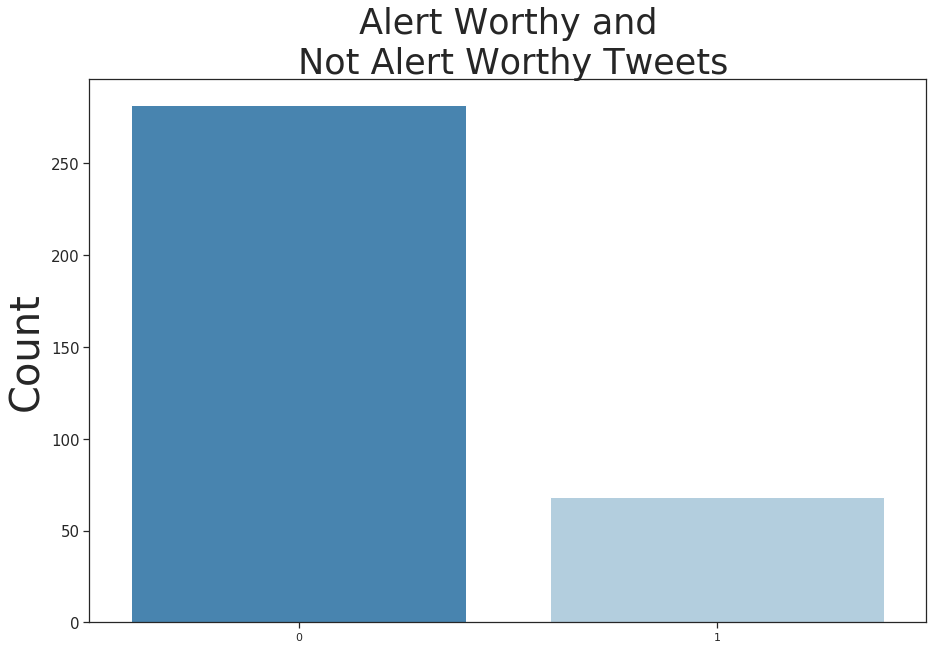

In [121]:
#Create a plot to show imbalanced Classes
plt.figure(figsize = (15, 10))

sns.set() #(Re)set the seaborn default
sns.set_style("whitegrid") #Set the matplotlib parameters
sns.set_style("ticks", {"xtick.major.size":15,
"ytick.major.size":15})
sns.axes_style("whitegrid")

sns.countplot(data = df, x='tsunami', palette = 'Blues_r', )
plt.title(label = ' Alert Worthy and \n Not Alert Worthy Tweets', 
          fontsize = 35)
plt.ylabel('Count', fontsize = 40)
plt.xlabel('')
#plt.xticks('Not Alert Worthy', 'Alert Worthy')
plt.yticks(fontsize = 15)



;

Our data set has significantly unbalanced classes, so we have to determine a method to synthetically balance the classes. Instead of oversampling with replacement using sklearn, we will utilize SMOTE or Synthetic Minority Oversampling Technique to acheive this. The main issue of over sampling with replacement is that it leads to overfit models. SMOTE is able to add data points based on interpolation. 

<br>

After we preprocess our dataset for model fitting and testing, we will first explore what value for k works best for our model and how this will improve our accuracy scores for each model that we want to investigate. Next, we will try two additional resampling techniques to try to optimize.

## Lemmatization

In [6]:
#instatiate
lemmatizer = WordNetLemmatizer()

In [7]:
def lemmatized_column(df, col):
    lemmatized_col = []
    for i in list(range(len(col))):
        text = col[i]
         # Remove non-letters        
        letters_only = re.sub("[^a-zA-Z]", " ", text)
        #
        # Convert to lower case, split into individual words
        words = letters_only.split()
        #
        #convert the stop words to a set
        stops = set(stopwords.words('english')) 
        # 
        # Remove stop words
        meaningful_words = [w for w in words if not w in stops]
        #
        #exclude some key words - If necessary.
#         new_stops = ['lotr', 'asoiaf', 
#                      'lord', 'rings', 
#                      'ring', 'game', 
#                      'throne', 'thrones']
#         more_meaningful_words = [w for w in meaningful_words if not w in new_stops]
        #
        lemmed_words = [lemmatizer.lemmatize(i) for i in meaningful_words]
        #Join the words back into one string separated by space, 
        # 
        joined_words = ' '.join(lemmed_words)
        lemmatized_col.append(joined_words)
        
    df['lemmatized'] = lemmatized_col
    return lemmatized_col

In [8]:
#save a new column as the lemmatized column
new_column = lemmatized_column(df, df.tweet)

In [9]:
df.head()

,tsunami,tweet,lemmatized
0,0,I feel so lucky rn,I feel lucky rn
1,0,@AshNiggas tink ...,AshNiggas tink
2,1,So did we have a hurricane tornado tsunami? So...,So hurricane tornado tsunami Someone please te...
3,1,@helene_yancey GodsLove &amp; #thankU my siste...,helene yancey GodsLove amp thankU sister Helen...
4,0,I liked a @YouTube video from @team0epiphany h...,I liked YouTube video team epiphany http co ku...


## Vectorization

In [10]:
def vectorize_tweets(method, col, df):
    #Instantiate
    vect = method()
    
    #fit and transform X_train
    vect.fit(df[col])
    columns_vect = vect.transform(df[col])
    
    #turn both train and  test into dataframes
    vect_df = pd.DataFrame(columns_vect.todense(), columns= vect.get_feature_names())
    
    
    return vect_df

In [11]:
count_df = vectorize_tweets(CountVectorizer, 'lemmatized', df)
#tfidf_df = vectorize_tweets(TfidfVectorizer, 'lemmatized', df)
#hash_df = vectorize_tweets(HashingVectorizer, 'lemmatized', df)

In [13]:
count_df.head()

,aade,aasfmvbl,able,about,above,absirfimrankhan,absolute,accnrnc,according,accuse,...,zjm,znof,zone,zrekuvo,zrx,zs,zt,ztr,zy,zz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
count_df['y_target'] = df['tsunami']

In [18]:
count_df.head()

,aade,aasfmvbl,able,about,above,absirfimrankhan,absolute,accnrnc,according,accuse,...,znof,zone,zrekuvo,zrx,zs,zt,ztr,zy,zz,y_target
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [183]:
model_columns = count_df.columns

In [185]:
len(model_columns)

2930

### Drop unecessary columns
*Note: Create list of columns fulfilling requirement and then drop those *

In [16]:
def drop_cols(df, n):
    for col in df.columns:
        if df[col].sum() < n:
            df.drop(col, axis = 1, inplace= True)
    return df

## Rebalance Classes

We're going to explore the f1 score for the minority group using different k's and then plots the resulting score against the chosen k. We will use this plot to determine the optimal k to maximize the predictions of our minority group, where tsunami = 1.

In [162]:
#Instantiate a model
#lr = LogisticRegression()

def find_ks(models, X_train, X_test, y_train, y_test):
    model_dict = {}
    for m in models:
        scores = {}
        model = m
        for k in range(1,20):
            #Instantiate Smote
            sm = SMOTE(ratio = 'minority', k_neighbors=k, random_state=240)
            #Fit smote
            X_smote, y_smote = sm.fit_sample(X_train, y_train)
            #Fit model
            model.fit(X_smote,y_smote)
            #Predict
            smote_predict = model.predict(X_test)
            #Find f1 score
            f1_smote = f1_score(y_test, smote_predict)
            #add f1 
            scores[k] = f1_smote
            sns.set_style("whitegrid") #Set the matplotlib parameters
            plt.scatter(k, f1_smote)
            plt.title(label = m)
        model_dict[m] = scores
        
    return model_dict
        

{LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='warn',
           n_jobs=None, penalty='l2', random_state=None, solver='warn',
           tol=0.0001, verbose=0, warm_start=False): {1: 0.5333333333333333,
  2: 0.5106382978723405,
  3: 0.5,
  4: 0.4583333333333333,
  5: 0.5106382978723405,
  6: 0.5490196078431372,
  7: 0.5,
  8: 0.5306122448979592,
  9: 0.5199999999999999,
  10: 0.5,
  11: 0.5306122448979592,
  12: 0.5306122448979592,
  13: 0.48000000000000004,
  14: 0.5599999999999999,
  15: 0.5416666666666666,
  16: 0.5306122448979592,
  17: 0.5833333333333333,
  18: 0.5416666666666666,
  19: 0.5714285714285714},
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0

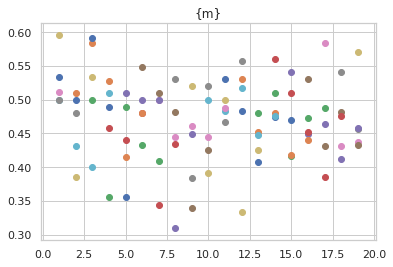

In [163]:
find_ks(models, X_train, X_test, y_train, y_test)

The f1 scores of note using regular X and y train/test split data were for a Decision Tree Classifier with a k value of 3 (0.58), a Bagging Classifier with a k value of 3 (0.59), and a Logistic Regression with a k value of 17 (0.58).

In [164]:
X = count_df.drop('y_target', axis = 1)
y = count_df['y_target']

In [170]:
#Instantiate and fit the SMOTE rebalancing using k = 17 for Logistic Regression
sm = SMOTE(ratio='minority',k_neighbors=17, random_state=240)
X_smote, y_smote = sm.fit_sample(X, y)

In [173]:
len(X_smote)

564

In [174]:
len(y_smote)

564

## Train/Test Split: unchanged data

In [171]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify=y)

In [20]:
X_train.head()

,aade,aasfmvbl,able,about,above,absirfimrankhan,absolute,accnrnc,according,accuse,...,zjm,znof,zone,zrekuvo,zrx,zs,zt,ztr,zy,zz
280,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
179,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
214,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Train/Test Split: Rebalanced Data

In [175]:
X_smote_train, X_smote_test, y_smote_train, y_smote_test = train_test_split(X_smote, 
                                                                            y_smote, 
                                                                            random_state = 42)

## Principle Component Analysis (PCA) with imbalanced classes

In [21]:
pca = PCA()
pca.fit(X_train)

Z_train = pca.transform(X_train)
Z_test = pca.transform(X_test)

In [123]:
len(pca.components_)

262

## PCA with SMOTE rebalanced data

In [178]:
pca_smote = PCA()
pca_smote.fit(X_smote_train)

Z_smote_train = pca_smote.transform(X_smote_train)
Z_smote_test = pca_smote.transform(X_smote_test)

## Cross Validation
It's important to understand which metric to optimize on. In this case, we will aim to optimize on f-1 score as it takes into account both precision and recall.

In [136]:
#Create a function to iterate through multiple cross validation scores and put them in a dataframe

#Models is a list of models to cross val score on
def find_cross_val_f1(models, X, y, cv):
    scores = {}
    for i in models: 
        scores[str(i)] = cross_validate(i, X, y, cv = 5, scoring='f1')['test_score'].mean()
    return scores
#pd.DataFrame(scores, columns = ['model', 'cv_score'])

In [155]:
models = [LogisticRegression(), 
          DecisionTreeClassifier(), 
          BaggingClassifier(), 
          RandomForestClassifier(), 
          AdaBoostClassifier(), ]

In [35]:
cross_val_score(LogisticRegression(), Z_train, y_train, cv = 5).mean()

0.8545584045584047

In [38]:
cv_scores = find_cross_val_scores(models, Z_train, y_train, 5)

Below are the accuracy scores of cross validation from five different models.

In [46]:
pd.DataFrame(cv_scores, index = range(0,1))

,"LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=None, penalty='l2', random_state=None, solver='warn', tol=0.0001, verbose=0, warm_start=False)","DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, presort=False, random_state=None, splitter='best')","BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False, max_features=1.0, max_samples=1.0, n_estimators=10, n_jobs=None, oob_score=False, random_state=None, verbose=0, warm_start=False)","RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini', max_depth=None, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None, oob_score=False, random_state=None, verbose=0, warm_start=False)","AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0, n_estimators=50, random_state=None)"
0,0.854558,0.756838,0.787037,0.801709,0.802279


However, we are more interested in the f1 scores, which can be seen below.

In [138]:
f1_scores = find_cross_val_f1(models, Z_train, y_train, cv = 5)

/Users/edithiyerhernandez/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [139]:
pd.DataFrame(f1_scores, index = range(0,1))

,"LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=None, penalty='l2', random_state=None, solver='warn', tol=0.0001, verbose=0, warm_start=False)","DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, presort=False, random_state=None, splitter='best')","BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False, max_features=1.0, max_samples=1.0, n_estimators=10, n_jobs=None, oob_score=False, random_state=None, verbose=0, warm_start=False)","RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini', max_depth=None, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None, oob_score=False, random_state=None, verbose=0, warm_start=False)","AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0, n_estimators=50, random_state=None)"
0,0.492605,0.417899,0.165983,0.20696,0.375


### Which models performed the best before rebalancing the classes

#### Accuracy
1. Logistic Regression: 0.854558
2. Random Forest: 0.801709
3. AdaBoost Classifier: 0.802279

#### F1 Score
1. Logistic Regression: 0.492605
2. Decision Tree Classifier: 0.417899

Below, we will run the cross validated f1 scores using SMOTE rebalanced data optimized for Logistic Regression with `k = 17`.

In [182]:
pd.DataFrame((find_cross_val_f1(models, Z_smote_train, y_smote_train, 5)), index = range(0,1))

,"LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=None, penalty='l2', random_state=None, solver='warn', tol=0.0001, verbose=0, warm_start=False)","DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, presort=False, random_state=None, splitter='best')","BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False, max_features=1.0, max_samples=1.0, n_estimators=10, n_jobs=None, oob_score=False, random_state=None, verbose=0, warm_start=False)","RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini', max_depth=None, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None, oob_score=False, random_state=None, verbose=0, warm_start=False)","AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0, n_estimators=50, random_state=None)"
0,0.826195,0.856884,0.854783,0.869817,0.864876


### Which models performed best after SMOTE transform

#### F1 Scores
1. Random Forest: 0.869817
2. AdaBoost: 0.864876
<br>

This is surprising because we optimized the k value for Logistic Regression that we found earlier when performing a manual gridsearch on possible k values. A few of the other models had the highest scores when using k = 3 or k =4. We will therefore try both of these using the function `smote_pca_cross_val()`.


In [191]:
def smote_pca_cross_val(k, X, y, models):
    sm = SMOTE(ratio='minority', k_neighbors=k, random_state = 240)
    X_smote, y_smote = sm.fit_sample(X, y)
    X_smote_train, X_smote_test, y_smote_train, y_smote_test = train_test_split(X_smote,
                                                                                y_smote,
                                                                               random_state = 42)
    pca_smote = PCA()
    pca_smote.fit(X_smote_train)
    
    Z_smote_train = pca_smote.transform(X_smote_train)
    Z_smote_test = pca_smote.transform(X_smote_test)
    
    return pd.DataFrame((find_cross_val_f1(models, Z_smote_train, y_smote_train, 5)), index = range(0,1))

### k = 4

In [192]:
smote_pca_cross_val(4, X, y, models)

,"LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=None, penalty='l2', random_state=None, solver='warn', tol=0.0001, verbose=0, warm_start=False)","DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, presort=False, random_state=None, splitter='best')","BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False, max_features=1.0, max_samples=1.0, n_estimators=10, n_jobs=None, oob_score=False, random_state=None, verbose=0, warm_start=False)","RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini', max_depth=None, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None, oob_score=False, random_state=None, verbose=0, warm_start=False)","AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0, n_estimators=50, random_state=None)"
0,0.827008,0.843405,0.8981,0.865228,0.891041


### k = 3

In [193]:
smote_pca_cross_val(3, X, y, models)

,"LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=None, penalty='l2', random_state=None, solver='warn', tol=0.0001, verbose=0, warm_start=False)","DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, presort=False, random_state=None, splitter='best')","BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False, max_features=1.0, max_samples=1.0, n_estimators=10, n_jobs=None, oob_score=False, random_state=None, verbose=0, warm_start=False)","RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini', max_depth=None, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None, oob_score=False, random_state=None, verbose=0, warm_start=False)","AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0, n_estimators=50, random_state=None)"
0,0.836859,0.832688,0.885361,0.890842,0.89035


The most notable models are:
1. Bagging Classifier, k = 4: f1 = 0.8981
2. AdaBoost Classifier, k = 4: f1 = 0.891041 

We will now fit and evaluate both models on the the testing dataset

### Bagging Classifier:

In [199]:
# SMOTE
#Instantiate
sm = SMOTE(ratio='minority', k_neighbors=4, random_state = 240)
#Fit SMOTE
X_smote, y_smote = sm.fit_sample(X, y)

#Train/Test Splite with smote data
X_smote_train, X_smote_test, y_smote_train, y_smote_test = train_test_split(X_smote,
                                                                                y_smote,
                                                                               random_state = 42)
#PCA Instantiate
pca_smote = PCA()
#Fit PCA on training data
pca_smote.fit(X_smote_train)
 
#Create Z_train and Z_test
Z_smote_train = pca_smote.transform(X_smote_train)
Z_smote_test = pca_smote.transform(X_smote_test)

In [200]:
#Instantiate Bagging Classifier
bag = BaggingClassifier(random_state = 42)

bag.fit(Z_smote_train, y_smote_train)

bag_preds = bag.predict(Z_smote_test)

f1_score(y_smote_test, bag_preds)

0.7087378640776698

### AdaBoost Classifier:

In [230]:
ada = AdaBoostClassifier(random_state = 42)

ada.fit(Z_smote_train, y_smote_train)

ada_preds = ada.predict(Z_smote_test)

f1_score(y_smote_test, ada_preds)

0.6990291262135921

In [233]:
ada_matrix = pd.DataFrame(np.array(confusion_matrix(y_smote_test, ada_preds)),
                         index = ['Not Alert Worthy', 'Alert Worthy'],
                        columns=['Predicted Not Alert Worthy','Predicted Alert Worthy'])

In [234]:
ada_matrix

,Predicted Not Alert Worthy,Predicted Alert Worthy
Not Alert Worthy,7,60
Alert Worthy,2,72


Both models tested actually show significant signs of overfitting to the training data. 

In [228]:
def create_confusion(y_true, y_pred):
    con_mat = pd.DataFrame(np.array(confusion_matrix(y_test, y_pred)), 
                           index = ['Not Alert Worthy', 'Alert Worthy'],
                           columns = ['Predicted Not Alert Worthy', 'Predicted Alert Worthy'])
    #hm = sns.heatmap(con_mat.apply(lambda x: x/x.sum(), axis = 1, annot =True, cmap = 'Blues'))
    return con_mat

def create_heatmap(confusion_matrix):
    return sns.heatmap(confusion_matrix.apply(lambda x: x/x.sum(), axis = 1), annot = True, cmap = 'Blues', 
                       annot_kws={"size": 30})

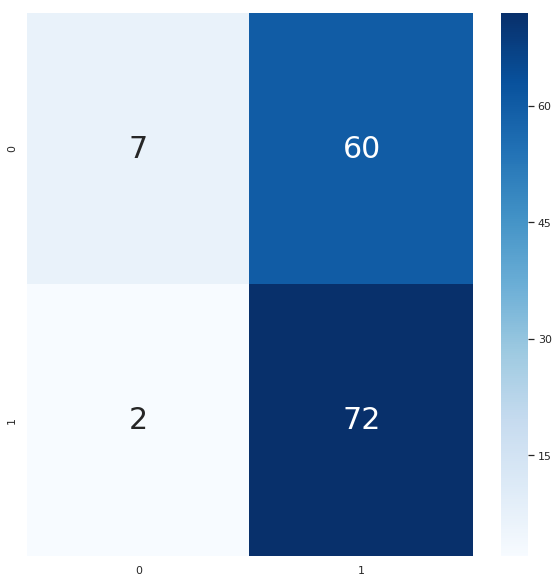

In [239]:
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(y_smote_test, ada_preds), annot = True, cmap = 'Blues', annot_kws={'size': 30})

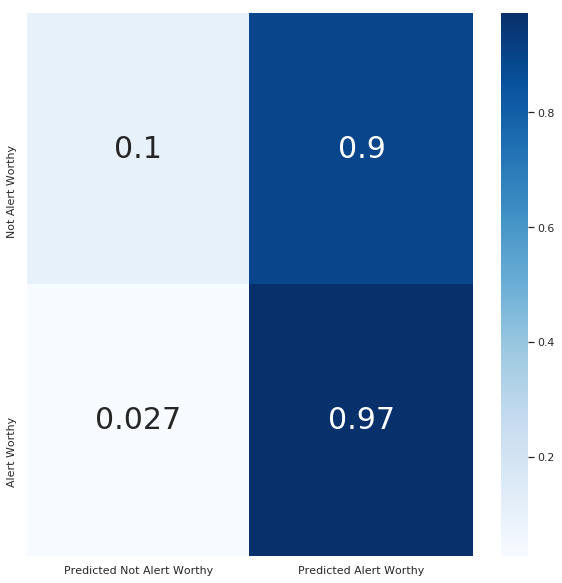

In [237]:
plt.figure(figsize=(10, 10))
create_heatmap(ada_matrix)

## Top Model GridSearch

In order to decide on a model, we must gridsearch for each of the top scoring models according to the f1 cross validated scores.
<br>

#### Bagging Classifier:
Original Parameters:
<br>
base_estimator=None, bootstrap=True, bootstrap_features=False, max_features=1.0, max_samples=1.0, n_estimators=10, n_jobs=None, oob_score=False, random_state=None, verbose=0, warm_start=False
<br>
We will gridsearch through:
- max_features(1, 5, 10, 20, 30)
- max_samples (1, 5, 10)
- n_estimators(10, 20, 30, 50, 80, 120)

#### ADABoost Classifier
Original Parameters:
<br>
algorithm='SAMME.R', base_estimator=None, learning_rate=1.0, n_estimators=50, random_state=None
<br>
Boosting is challenging to gridsearch through.

In [70]:
cv = KFold(n_splits = 5, random_state = 42)

In [71]:
#Create a gridsearch model
def gridsearch(X_train, y_train, mod, params, results_list):
    #create an empty dictionary to store the results in 
    details = {}
    #instantiate model from the mod input variable
    model = mod()
    
    #Call the model
    gs = GridSearchCV(model, param_grid = params, cv=cv) 
    #cv was defined earlier as cv = KFold(n_splits = 5, random_state = 203) to ensure random state)
    
    #fit model on the training data
    gs.fit(X_train, y_train)

    #add the information to a dictionary
    details['best score, ' + str(mod)] = {gs.best_score_ : gs.best_params_}
    
    #append the dictionary to the list to store
    results_list.append(details)
    
    
    return results_list

In [203]:
#create params list
params = {
        'n_estimators': [20, 50, 80],
        'max_features': [5, 10, 20, 30],
        'max_samples':[5, 10, 20, 30],
}

bagging_gs_results= []

#run the gridsearch
gridsearch(Z_smote_train, y_smote_train, BaggingClassifier, params, bagging_gs_results)
bagging_gs_results

/Users/edithiyerhernandez/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[{"best score, <class 'sklearn.ensemble.bagging.BaggingClassifier'>": {0.8770685579196218: {'max_features': 10,
    'max_samples': 20,
    'n_estimators': 80}}}]

In [204]:
#create params list
params = {
        'n_estimators': [50, 80, 120],
        'max_features': [10, 20, 30],
        'max_samples':[15, 20, 30],
}


#run the gridsearch
gridsearch(Z_smote_train, y_smote_train, BaggingClassifier, params, bagging_gs_results)
bagging_gs_results

/Users/edithiyerhernandez/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[{"best score, <class 'sklearn.ensemble.bagging.BaggingClassifier'>": {0.8770685579196218: {'max_features': 10,
    'max_samples': 20,
    'n_estimators': 80}}},
 {"best score, <class 'sklearn.ensemble.bagging.BaggingClassifier'>": {0.8888888888888888: {'max_features': 10,
    'max_samples': 30,
    'n_estimators': 120}}}]

We are going to test the bagging classifier with the above parameters on the testing set to see if we can improve our overall f1_score.

In [205]:
#Instantiate Bagging Classifier
bag = BaggingClassifier(max_features = 10,
                        max_samples = 30,
                        n_estimators = 120,
                        random_state = 42)

bag.fit(Z_smote_train, y_smote_train)

bag_preds = bag.predict(Z_smote_test)

f1_score(y_smote_test, bag_preds)

0.7093596059113302

In [215]:
#Look at Confusion Matrix for bagging classifier
bagging_cm = pd.DataFrame(np.array(confusion_matrix(y_smote_test, bag_preds)),
                         index = ['Not Alert Worthy', 'Alert Worth'],
                        columns=['Predicted Not Alert Worthy','Predicted Alert Worthy'])
bagging_cm

,Predicted Not Alert Worthy,Predicted Alert Worthy
Not Alert Worthy,10,57
Alert Worth,2,72


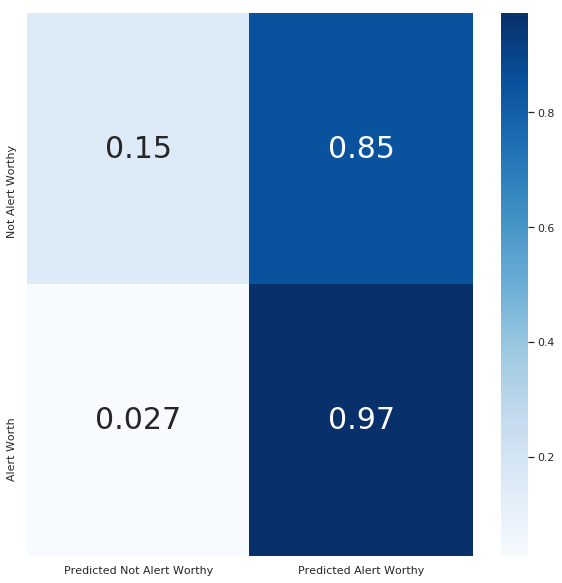

In [226]:
# Create a Heatmap
plt.figure(figsize=(10, 10))
create_heatmap(bagging_cm)

The confusion matrix above is important because it shows that we have very low false negatives. Another way to look at this is to say that we want to minimize false negatives, therefore, we want to look at the recall. Which is $TP/(TP + FN) = 72/(72+ 2) = 0.97$.


In [207]:
# Check out confusion matrices for each of the best models with their parameters
cm = confusion_matrix

In [48]:
logreg = LogisticRegression()

logreg.fit(Z_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [49]:
logreg.score(Z_train, y_train)

1.0

In [50]:
#On PCA data
logreg.score(Z_test, y_test)

0.8409090909090909

In [51]:
lr = LogisticRegression()

lr.fit(X_train, y_train)
lr.score(X_train, y_train)

1.0

In [52]:
#On non PCA data
lr.score(X_test, y_test)

0.8295454545454546

In [64]:
lr_confusion = pd.DataFrame(np.array(confusion_matrix(y_test, lr.predict(X_test))),
                         index = ['is_not_alert_worthy', 'is_alert_worthy'],
                        columns=['predicted_not_alert_worthy','predicted_alert_worthy'])
lr_confusion

,predicted_not_alert_worthy,predicted_alert_worthy
is_not_alert_worthy,68,3
is_alert_worthy,12,5


In [90]:
rf_cm = create_confusion(y_test, rf.predict(Z_test))

In [96]:
rf_cm

,Predicted Not Alert Worthy,Predicted Alert Worthy
Not Alert Worthy,71,0
Alert Worthy,17,0


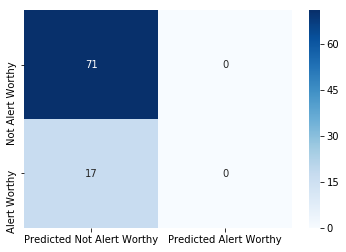

In [103]:
create_heatmap(rf_cm)

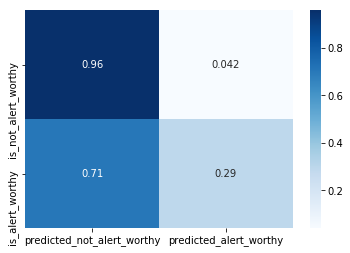

In [86]:
sns.heatmap(lr_confusion.apply(lambda x: x/x.sum(),axis=1), annot=True, cmap = 'Blues');

In [62]:
confusion_matrix(y_test, lr.predict(X_test))

array([[68,  3],
       [12,  5]])

In [53]:
lr.coef_

array([[-0.07338688,  0.        ,  0.        , ..., -0.0587897 ,
         0.        ,  0.        ]])

In [57]:
lr_coefs = pd.DataFrame(lr.coef_, columns= X_train.columns).T

In [61]:
lr_coefs.sort_values(0, ascending=False).head(20)

,0
palu,1.047548
breaking,0.971125
indonesia,0.932676
co,0.879174
hit,0.872561
killed,0.700209
clear,0.650589
kill,0.628155
volcano,0.575490
prayforanyer,0.570985


# Final Model:
Custom Lemmatization
<br>
CountVectorized Tweets
<br>
Corrected for imbalanced classes using SMOTE
<br>
Dimensionality Reduction through PCA
<br>
AdaBoost Classifier with standard hyperparameters

|Model   |Name   |  
|---|---|
|AdaBoost Classifier   |`ada`   | 





In [241]:
# input tweets as dataframe that has an index column and 'tweet' column

def preprocess_ada_model(df, column, method):
    #Lemmatize tweets
    lemmed_df = lemmatized_column(df, column)
    #Countvectorize tweets
    new_df = vectorize_tweets(method, 'lemmatized', lemmed_df)
    #Check to see if tweet words are in columns used in building the model
    test_columns = []
    for col in count_df.columns:
        if col not in model_columns:
            test_columns.append(col)
    new_df.drop(test_columns, axis = 1, inplace=True)
    
    # PCA transformation
    new_model = pca_smote.transform(new_df)
    
    #Model Prediction
    preds = ada.predict(new_model)
    
    if preds.sum() > 5:
        print('Oh No')
    else:
        print('restart')
    return preds.sum()
    